## Converting replay files to a more tractable format

Over the course of the past 2 weeks, I've been working with a collection of 423 replay files. Working with these games has been incredibly fruitful in building helper functions, testing models, and performing feature selection and feature engineering.

Loading these 423 games into memory takes a manageable 5 minutes (in an early 2013 15'' MacBook Pro).

If we low-ball the number of times I've restarted my notebook to once a day, we see a collective time spent waiting for these games to load of 1h. If we further include each voluntary and involuntary restarting of the kernel and reloading of the data, we see that that estimate was in reality not in the right order of magnitude.

This notebook seeks to mitigate this issue moving foward, in particular before we seek to tackle further replay files available to us through webscraping, including:

    - the 7200 pro replays available at http://lotv.spawningtool.com/
    - the 16,000+ gand-master and master replays readily www.gamereplays.org
    
    - the 25,000+ mixed-skill replays at http://lotv.spawningtool.com/
    - the 65,000+ mixed-skill replays at www.gamereplays.org
    
It is also worth noting that Blizzard (in partnership with Google Deep Mind) recently released 35,000 anonymized replay files for the purposes of A.I. research, and that they intend for this dataset to grow to 500,000 by the end of the year.

At close to 1 minute per 100 replays, we wish the matter of efficiently storing and retrieving replay data to be settled, so that we may implement it only once.

### Limitations when working with .SC2Replay files

The replay file format (as tractable by sc2reader and the StarCraft II game engine) poses two challenges:

    - a signigicant amount of time is spent parsing each .SC2Replay file into a python object
    - the resulting object is rather large

In [1]:
#%run ./Scripts/mklib.py 

import sc2reader
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
path_to_games = '../../../sc2games'
replay_file = path_to_games + '/IEM XI - World Championship - StarCraft II Replays/RO12 + Final/1. Round of 12/INnoVation vs Ryung/Cactus Valley LE (Void) (2).SC2Replay'
reaplay = sc2reader.load_replay(replay_file, load_level = 3)

In [3]:
%%timeit
sc2reader.load_replay(replay_file, load_level = 4)

345 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
replay = sc2reader.load_replay(replay_file, load_level = 4)

replay.registered_datapacks = None
replay.registered_readers = None
replay.logger = None
replay.factory = None

byte_full_replay = pickle.dumps(replay)

print('kbytes:',len(byte_full_replay)/1000)

kbytes: 3360.356


### The solution available through sc2reader

Fortunately, we can easily parse only some of the replay file, thus cutting loading time and memory consumption by close to 75%.

In [5]:
%%timeit
sc2reader.load_replay(replay_file, load_level = 3)

86.2 ms ± 7.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
replay = sc2reader.load_replay(replay_file, load_level = 3)

replay.registered_datapacks = None
replay.registered_readers = None
replay.logger = None
replay.factory = None

byte_load_3_replay = pickle.dumps(replay)
print('kbytes:',len(byte_load_3_replay)/1000)

kbytes: 863.938


However, at this rate the 35,000 games recently released by Google would consume 30Gb, and take close to 45 minutes to be parsed into python objects.

Arguably this is tractable, but we would rather not wait the 45 minutes python takes to parse the heavily compressed hexadecimal .SC2Reader files each time we wish to run our notebook. Preferably, the parsing would be done only once.

### Bypassing the parsing of the files

We wish to store the parsed files in such a manner as cuts down the time spent querying them for features or loading them in full. 

Were these parsed files tabular, we would probably use a postgress SQL database; were they jason-like, we might consider using MongoDB.

Unfortunately the python object outputed by sc2reader is far from being tabular or jason-like. 

This leaves us with two options:

    - pickling the object 'as is'
    - coercing the objects into a more tractable stucture for the purposes of storage

### Pickling sc2reader's replay objects

In [7]:
with open('./Resources/load_3_replay_pickled.p','wb') as my_file:
    pickle.dump(replay, my_file)

In [8]:
%%timeit
with open('./Resources/load_3_replay_pickled.p','rb') as my_file:
    pickle.load(my_file)

18.4 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


It's nice to see that our expected wait time has decreased by over 70%.

However, we can improve upon this.

### Converting sc2reader's replay objects to dictionaries

In this section we develop a function that will:

    - transverse the replay object
    - extract all information of interest
    - return it as a dictionary containing only in-built python types

In [9]:
# Defining helper functions
def getEvent(name = '', replay = None):
    return list({event for event in replay.events if name in event.name})

In [10]:
# Handling units and unit owners
def to_dictOwner(player):
    player_dict = {}
    if player != None:
        player_dict['owner'] = player.pid
    else:
        player_dict['owner'] = -1
    return player_dict

def to_dictUnit(unit):
    wish_to_ignore = ['__','_type_class','flags','apply_flags', 'is_type', 'set_type','type_history','type']
    unit_dict = {key:unit.__getattribute__(key) for key in unit.__dir__() 
            if all([ignore not in key for ignore in wish_to_ignore])}
    
    # Removing references to player objects
    unit_dict.update(to_dictOwner(unit_dict['owner']))
    if unit_dict['killed_by'] !=None:
        unit_dict['killed_by'] = unit_dict['killed_by'].pid
        unit_dict['killing_player'] = unit_dict['killed_by']
    
    # Removing references to unit objects
    unit_dict['killed_units'] = [unit.id for unit in unit_dict['killed_units']]
    if type(unit_dict['killing_unit']) != type(None):
        unit_dict['killing_unit'] = unit_dict['killing_unit'].id
        
    return unit_dict

In [11]:
# Handling events
def to_dictPlayerStatsEvent(event):
    wish_to_ignore = ['ff_','player','stats','name']
    return {key.replace('food', 'supply'):event.__dict__[key] for key in event.__dict__.keys() 
            if all([ignore not in key for ignore in wish_to_ignore])}

def to_dictUnitPositionsEvent(event):
    return {'positions':{unit_update[0]:unit_update[1] for unit_update in event.positions},
            'frame':event.frame,
            'second':event.second}

def to_dictUpgradeCompleteEvent(event):
    return {'upgrade_type_name':event.upgrade_type_name,
            'frame': event.frame,
            'second': event.second,
            'pid': event.pid}

def to_dictEvent(event):
    if event.name == 'PlayerStatsEvent':
        return to_dictPlayerStatsEvent(event)
    elif event.name == 'UnitPositionsEvent':
        return to_dictUnitPositionsEvent(event)
    elif event.name == 'UpgradeCompleteEvent':
        return to_dictUpgradeCompleteEvent(event)

In [12]:
# Helper functions
def to_dictContext(replay):
    try:
        return sc2reader.utils.toDict(replay)
    except:
        return replay.context
    
def to_dictObjects(replay):
    return {key:to_dictUnit(replay.objects[key]) for key in replay.objects.keys()}

def to_dictEvents(name, replay):
    events = getEvent(name, replay)
    return [to_dictEvent(event) for event in events]

In [13]:
# Main function
def to_dictReplay(replay):
    replay_dict = {}
    replay_dict['context'] = to_dictContext(replay)
    replay_dict['objects'] = to_dictObjects(replay)
    replay_dict['player_stats'] = to_dictEvents('PlayerStatsEvent', replay)
    replay_dict['unit_positions'] = to_dictEvents('UnitPositionsEvent', replay)
    replay_dict['upgrades'] = to_dictEvents('UpgradeCompleteEvent', replay)
    return replay_dict

At this point, the output of to_dictReplay is a dictionary with more dictionaries nested within it - ultimately terminating in integers, floats, booleans and strings and as such it could be converted to a jason.

Consider the current state of our metrics of interest (loading time, and memory consumption):

In [14]:
dict_replay = to_dictReplay(reaplay)
byte_dict_replay = pickle.dumps(dict_replay)

with open('./Resources/dict_replay_pickled.p','wb') as my_file:
    pickle.dump(dict_replay, my_file)

print('kbytes:',len(byte_dict_replay)/1000)

kbytes: 195.355


In [15]:
%%timeit
with open('./Resources/dict_replay_pickled.p','rb') as my_file:
    pickle.load(my_file)

2.49 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We are pleased with this further 88% decrease in loading time and memory usage. But we can do one better...

### Leveraging the consistency of schema

Our current dictionary representation of units and events is somewhat redundant:

    - Every unit has a name, an owner, a time of birth, a time of death... 
    - Every PlayerStats event contains all the same attributes.

It is easy to see that some improvement to performance may be gained by leveraging this consistency of schema.

We create a 'canonical' order for these attributes, and then store only their values, in that 'canonical' order. Hence we avoid the reiteration of the dozen-or-so keys across each instance of a dictionary describing a unit or event.

In [16]:
def dict_to_values(key_order, dictionary):
    return [dictionary[key] for key in key_order]

def to_lean_dict(dict_replay, look_up = False, deduce = False):
    object_keys = sorted(list(list(dict_replay['objects'].values())[0].keys()))
    player_stat_keys = sorted(list(dict_replay['player_stats'][0].keys()))
    
    if look_up == True:
        can_be_looked_up = ['is_army','is_worker','is_building','minerals','supply','title','vespene']
        object_keys = [key for key in object_keys if key not in can_be_looked_up]
        
    if deduce == True:
        player_stat_keys = sorted(['frame','pid',
                                   'minerals_collection_rate','minerals_current',
                                   'minerals_used_in_progress_army',
                                   'minerals_used_in_progress_economy',
                                   'minerals_used_in_progress_technology',
                                   'vespene_collection_rate','vespene_current',
                                   'vespene_used_in_progress_army',
                                   'vespene_used_in_progress_economy',
                                   'vespene_used_in_progress_technology'])

    lean_replay = dict_replay.copy()
    lean_replay['object_keys'] = object_keys
    lean_replay['player_stat_keys'] = player_stat_keys   
    
    lean_replay['objects'] = {key: dict_to_values(object_keys, dict_replay['objects'][key]) for key in dict_replay['objects'].keys()}
    lean_replay['player_stats'] = [dict_to_values(player_stat_keys, event) for event in dict_replay['player_stats']]

    return lean_replay

In [17]:
lean_dict_replay = to_lean_dict(dict_replay)
byte_lean_dict_replay = pickle.dumps(lean_dict_replay)

with open('./Resources/lean_dict_replay_pickled.p','wb') as my_file:
    pickle.dump(lean_dict_replay, my_file)

print('kbytes:',len(byte_lean_dict_replay)/1000)

kbytes: 103.1


In [18]:
%%timeit
with open('./Resources/lean_dict_replay_pickled.p','rb') as my_file:
    pickle.load(my_file)

1.11 ms ± 79.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We are pleased with this further 50% decrese in loading time and memory usage.

But just one more...

### Dropping superfluous information

Lastly we note the results we obtain if we discard information that we can easily look up or deduce.


In [19]:
very_lean_dict_replay = to_lean_dict(dict_replay, look_up=True, deduce = True)
byte_very_lean_dict_replay = pickle.dumps(very_lean_dict_replay)

with open('./Resources/very_lean_dict_replay_pickled.p','wb') as my_file:
    pickle.dump(very_lean_dict_replay, my_file)

print('kbytes:',len(byte_very_lean_dict_replay)/1000)

kbytes: 67.907


In [20]:
%%timeit
with open('./Resources/very_lean_dict_replay_pickled.p','rb') as my_file:
    pickle.load(my_file)

851 µs ± 39.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We are pleased by this 33% improvment to memory usage 46% improvement in loading time.

In fact we are - finally - sufficiently pleased.

## Evaluating our results

In this notebook we have seen several ways of storing our data:

    - fully parsed replay
    - partially parsed replay
    - partially parsed replay as pickle
    - dictionary form of replay
    - lean dictionary form of replay
    - very lean dictionary form of replay
    
and at every stage we've obtained an improvement to loading time and memory usage.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

memory_usage = pd.Series(
    data = {'fully parsed replay':len(byte_full_replay)/1000,
            'partially parsed replay':len(byte_load_3_replay)/1000,
            'partially parsed replay as pickle':len(byte_load_3_replay)/1000,
            'dictionary form of replay':len(byte_dict_replay)/1000,
            'lean dictionary form of replay':len(byte_lean_dict_replay)/1000,
            'very lean dictionary form of replay':len(byte_very_lean_dict_replay)/1000}, 
    index = ['fully parsed replay','partially parsed replay','partially parsed replay as pickle',
             'dictionary form of replay','lean dictionary form of replay','very lean dictionary form of replay'])

loading_time = pd.Series(
    data = {'fully parsed replay':360/360,
            'partially parsed replay':86/360,
            'partially parsed replay as pickle':16/360,
            'dictionary form of replay':2.25/360,
            'lean dictionary form of replay':1.3/360,
            'very lean dictionary form of replay':0.7/360}, 
    index = ['fully parsed replay','partially parsed replay','partially parsed replay as pickle',
             'dictionary form of replay','lean dictionary form of replay','very lean dictionary form of replay'])

df = pd.concat([memory_usage,loading_time], axis=1)
df.columns = ['memory ussage (kb)','loading time (ratio)']
df

,memory ussage (kb),loading time (ratio)
fully parsed replay,3360.356,1.000000
partially parsed replay,863.938,0.238889
partially parsed replay as pickle,863.938,0.044444
dictionary form of replay,195.355,0.006250
lean dictionary form of replay,103.100,0.003611
very lean dictionary form of replay,67.907,0.001944


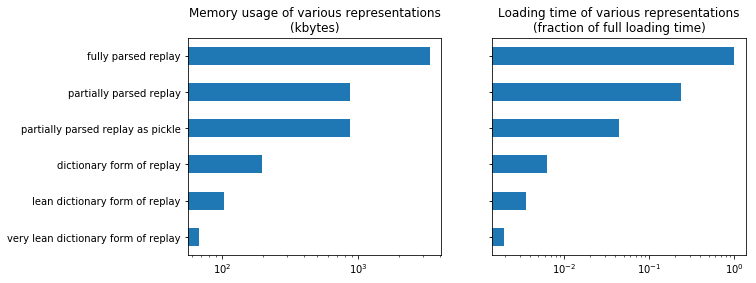

In [22]:
fig, axes = plt.subplots(ncols=2,nrows=1,sharey=True, figsize = (10,4))
memory_usage.sort_values().plot(
    kind='barh', logx = True, 
    title = 'Memory usage of various representations\n(kbytes)',
    ax = axes[0])

loading_time.sort_values().plot(
    kind='barh', logx = True, 
    title = 'Loading time of various representations\n(fraction of full loading time)',
    ax = axes[1])
plt.show()

In the end we obtained:
    
    - a 99.8% reduction to loading time compared to parsing the full replay file
    - a 99.0% reduction to loading time compared to partially parsing the replay file
    

In [23]:
def replay_to_dict(replay, look_up = True, deduce = True):
    return to_lean_dict(to_dictReplay(replay), look_up = look_up, deduce = deduce)

Furthermore, the run time of our replay_to_dict function is only 70% that of partially parsing the replay file.

In [24]:
%%timeit
replay_to_dict(replay)

60.1 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


and it is easy enough to querry the resulting dictionary for information

In [25]:
unit_info_df = pd.DataFrame(very_lean_dict_replay['objects']).T
unit_info_df.columns = very_lean_dict_replay['object_keys']
unit_info_df.head()

,died_at,finished_at,hallucinated,id,killed_by,killed_units,killing_player,killing_unit,location,name,owner,race,started_at
1,None,0,False,1,None,[],None,None,"(139, 141)",MineralField,-1,Neutral,0
262145,None,0,False,262145,None,[],None,None,"(140, 139)",MineralField750,-1,Neutral,0
524289,None,0,False,524289,None,[],None,None,"(96, 96)",XelNagaTower,-1,Neutral,0
786433,None,0,False,786433,None,[],None,None,"(36, 26)",VespeneGeyser,-1,Neutral,0
1048577,None,0,False,1048577,None,[],None,None,"(26, 154)",VespeneGeyser,-1,Neutral,0


In [26]:
player_stats_df = pd.DataFrame(very_lean_dict_replay['player_stats'])
player_stats_df.columns = very_lean_dict_replay['player_stat_keys']
player_stats_df.head()

,frame,minerals_collection_rate,minerals_current,minerals_used_in_progress_army,minerals_used_in_progress_economy,minerals_used_in_progress_technology,pid,vespene_collection_rate,vespene_current,vespene_used_in_progress_army,vespene_used_in_progress_economy,vespene_used_in_progress_technology
0,14880,2099,578,550,0,0,2,627,1061,125,0,0
1,17280,2351,388,1000,0,0,1,985,589,275,0,0
2,9440,2211,539,200,200,100,1,627,181,125,0,0
3,17280,1539,163,550,0,0,2,694,1004,125,0,0
4,8800,2771,172,500,300,100,1,649,24,275,0,100


## Rounding up
All definitions built throughout this notebook led up to:

    replay_to_dict 
    
running the code collated below will give access to replay_to_dict. 

_The only dependnecy is sc2reader_

In [1]:
import sc2reader

# Defining helper functions
def getEvent(name = '', replay = None):
    return list({event for event in replay.events if name in event.name})

# Handling units and unit owners
def to_dictOwner(player):
    player_dict = {}
    if player != None:
        player_dict['owner'] = player.pid
    else:
        player_dict['owner'] = -1
    return player_dict

def to_dictUnit(unit):
    wish_to_ignore = ['__','_type_class','flags','apply_flags', 'is_type', 'set_type','type_history','type']
    unit_dict = {key:unit.__getattribute__(key) for key in unit.__dir__() 
            if all([ignore not in key for ignore in wish_to_ignore])}
    
    # Removing references to player objects
    unit_dict.update(to_dictOwner(unit_dict['owner']))
    if unit_dict['killed_by'] !=None:
        unit_dict['killed_by'] = unit_dict['killed_by'].pid
        unit_dict['killing_player'] = unit_dict['killed_by']
    
    # Removing references to unit objects
    unit_dict['killed_units'] = [unit.id for unit in unit_dict['killed_units']]
    if type(unit_dict['killing_unit']) != type(None):
        unit_dict['killing_unit'] = unit_dict['killing_unit'].id
        
    return unit_dict

# Handling events
def to_dictPlayerStatsEvent(event):
    wish_to_ignore = ['ff_','player','stats','name']
    return {key.replace('food', 'supply'):event.__dict__[key] for key in event.__dict__.keys() 
            if all([ignore not in key for ignore in wish_to_ignore])}

def to_dictUnitPositionsEvent(event):
    return {'positions':{unit_update[0]:unit_update[1] for unit_update in event.positions},
            'frame':event.frame,
            'second':event.second}

def to_dictUpgradeCompleteEvent(event):
    return {'upgrade_type_name':event.upgrade_type_name,
            'frame': event.frame,
            'second': event.second,
            'pid': event.pid}

def to_dictEvent(event):
    if event.name == 'PlayerStatsEvent':
        return to_dictPlayerStatsEvent(event)
    elif event.name == 'UnitPositionsEvent':
        return to_dictUnitPositionsEvent(event)
    elif event.name == 'UpgradeCompleteEvent':
        return to_dictUpgradeCompleteEvent(event)
    
# Helper functions
def to_dictContext(replay):
    try:
        return sc2reader.utils.toDict(replay)
    except:
        return replay.context
    
def to_dictObjects(replay):
    return {key:to_dictUnit(replay.objects[key]) for key in replay.objects.keys()}

def to_dictEvents(name, replay):
    events = getEvent(name, replay)
    return [to_dictEvent(event) for event in events]

# Main function 1 of 2
def to_dictReplay(replay):
    replay_dict = {}
    replay_dict['context'] = to_dictContext(replay)
    replay_dict['objects'] = to_dictObjects(replay)
    replay_dict['player_stats'] = to_dictEvents('PlayerStatsEvent', replay)
    replay_dict['unit_positions'] = to_dictEvents('UnitPositionsEvent', replay)
    replay_dict['upgrades'] = to_dictEvents('UpgradeCompleteEvent', replay)
    return replay_dict

# Helper function
def dict_to_values(key_order, dictionary):
    return [dictionary[key] for key in key_order]

# Main function 2 of 2
def to_lean_dict(dict_replay, look_up = False, deduce = False):
    object_keys = sorted(list(list(dict_replay['objects'].values())[0].keys()))
    player_stat_keys = sorted(list(dict_replay['player_stats'][0].keys()))
    
    if look_up == True:
        can_be_looked_up = ['is_army','is_worker','is_building','minerals','supply','title','vespene']
        object_keys = [key for key in object_keys if key not in can_be_looked_up]
        
    if deduce == True:
        player_stat_keys = sorted(['frame','pid',
                                   'minerals_collection_rate','minerals_current',
                                   'minerals_used_in_progress_army',
                                   'minerals_used_in_progress_economy',
                                   'minerals_used_in_progress_technology',
                                   'vespene_collection_rate','vespene_current',
                                   'vespene_used_in_progress_army',
                                   'vespene_used_in_progress_economy',
                                   'vespene_used_in_progress_technology'])

    lean_replay = dict_replay.copy()
    lean_replay['object_keys'] = object_keys
    lean_replay['player_stat_keys'] = player_stat_keys   
    
    lean_replay['objects'] = {key: dict_to_values(object_keys, dict_replay['objects'][key]) 
                              for key in dict_replay['objects'].keys()}
    
    lean_replay['player_stats'] = [dict_to_values(player_stat_keys, event) 
                                   for event in dict_replay['player_stats']]

    return lean_replay

# Wrapper function for 1 and 2
def replay_to_dict(replay, look_up = True, deduce = True):
    return to_lean_dict(to_dictReplay(replay), look_up = look_up, deduce = deduce)

This code is saved as 

    replay_to_dict.py

and is part of the Scripts module we are building.